In [3]:
import os
import sys

In [4]:
IN_COLAB='google.colab' in sys.modules

if IN_COLAB:
    from google.colab import drive

    WORKING_FOLDER="/content/drive/MyDrive/unicamp/ia368v_dd/aula_09"

    drive.mount('/content/drive', force_remount=True)

    os.chdir(WORKING_FOLDER)
    
#     !python3.8 -m pip install openai -q
else:
    WORKING_FOLDER="/mnt/0060f889-4c27-409b-b0de-47f5427515e3/unicamp/ia368v_dd/ia368v_dd_class_09/"
    PYSERINI_FOLDER="/mnt/0060f889-4c27-409b-b0de-47f5427515e3/unicamp/ia368v_dd/pyserini/"
    
    os.environ["ANSERINI_CLASSPATH"]="/media/eduseiti/bigdata01/unicamp/ia368v_dd/anserini/target"

In [5]:
import pandas as pd
import pickle
import numpy as np

import json

import time

import re

from datetime import datetime

In [6]:
TREC_COVID_ORIGINAL_TITLE_TEXT_MERGED_FILENAME="trec_covid_original_title_text_merged.tsv"

TREC_COVID_MERGED_FILE="trec_covid_merged_data.tsv"
TREC_COVID_DOCUMENTS_FILE="trec_covid_original_title_text_merged.tsv"

TREC_COVID_QRELS="trec_covid_qrels.tsv"

API_KEYS_FILE="../api_keys_20230324.json"

In [7]:
TREC_COVID_QUERY_EXPANSION="eduseiti_1000_queries_expansion_20230502_01.jsonl"

TREC_COVID_QUERIES_BM25_FORMAT="trec_covid_LLM_queries_for_BM25.tsv"

In [8]:
PYSERINI_TOOLS_FOLDER=PYSERINI_FOLDER+"tools/scripts/msmarco/"

In [9]:
TREC_COVID_ORIGINAL_FOLDER="trec_covid_original"
TREC_COVID_ORIGINAL_INDEX_FOLDER="trec_covid_original/index"
TREC_COVID_ORIGINAL_RUNS_FOLDER="trec_covid_original/runs"

In [10]:
HOW_MANY_NEGATIVES=20

In [11]:
pd.set_option('display.max_colwidth', None)

## Set the random seed

In [12]:
RANDOM_SEED = 6

rng = np.random.default_rng(RANDOM_SEED)

### Read the LLM generated queries for TREC COVID

In [13]:
expanded_queries = []

with open(TREC_COVID_QUERY_EXPANSION, "r") as inputFile:
    for line in inputFile:
        expanded_queries.append(json.loads(line))

In [14]:
len(expanded_queries)

4914

In [15]:
expanded_queries_df = pd.DataFrame(expanded_queries)

#### Save the new queries in Pyserini-friendly format

In [16]:
expanded_queries_df['query'].to_csv(TREC_COVID_QUERIES_BM25_FORMAT, sep='\t', header=None)

### Convert TREC COVID to Pyserini's format

In [ ]:
!python3.8 {PYSERINI_TOOLS_FOLDER}convert_collection_to_jsonl.py \
    --collection-path {TREC_COVID_ORIGINAL_TITLE_TEXT_MERGED_FILENAME} \
    --output-folder {TREC_COVID_ORIGINAL_FOLDER}

### Create a Pyserini BM25 index for the entire TREC COVID dataset

In [ ]:
os.chdir(PYSERINI_FOLDER)

In [ ]:
!python3.8 -m pyserini.index.lucene \
    --collection JsonCollection \
    --input {WORKING_FOLDER}{TREC_COVID_ORIGINAL_FOLDER} \
    --index {WORKING_FOLDER}{TREC_COVID_ORIGINAL_INDEX_FOLDER} \
    --generator DefaultLuceneDocumentGenerator \
    --threads 9 \
    --storePositions --storeDocvectors --storeRaw

### Execute the expanded TREC COVID queries using BM25 over the complete dataset

In [17]:
execution_timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")

pyserini_runfile = "run.trec_covid_original_{}.txt".format(execution_timestamp)

In [18]:
!python3.8 -m pyserini.search.lucene \
    --index {WORKING_FOLDER}{TREC_COVID_ORIGINAL_INDEX_FOLDER} \
    --topics {WORKING_FOLDER}{TREC_COVID_QUERIES_BM25_FORMAT} \
    --output {WORKING_FOLDER}{TREC_COVID_ORIGINAL_RUNS_FOLDER}/{pyserini_runfile} \
    --output-format trec \
    --hits 1000 \
    --bm25 --k1 0.82 --b 0.68 \
    --threads 8

Setting BM25 parameters: k1=0.82, b=0.68
Running /mnt/0060f889-4c27-409b-b0de-47f5427515e3/unicamp/ia368v_dd/ia368v_dd_class_09/trec_covid_LLM_queries_for_BM25.tsv topics, saving to /mnt/0060f889-4c27-409b-b0de-47f5427515e3/unicamp/ia368v_dd/ia368v_dd_class_09/trec_covid_original/runs/run.trec_covid_original_20230503_201050.txt...
100%|███████████████████████████████████████| 4914/4914 [04:18<00:00, 18.98it/s]


### Check the BM25 search results

In [19]:
os.chdir(WORKING_FOLDER)

In [20]:
qrels_df = pd.read_csv(os.path.join(TREC_COVID_ORIGINAL_RUNS_FOLDER, pyserini_runfile), 
                       sep=' ', 
                       header=None,
                       names=['query-id', 'Q0', 'doc-id', 'doc-order', 'doc-score', 'comment'])

In [21]:
qrels_df

,query-id,Q0,doc-id,doc-order,doc-score,comment
0,0,Q0,pxniqk3i,1,16.134199,Anserini
1,0,Q0,aiksdnjc,2,14.399900,Anserini
2,0,Q0,9pmg7l7h,3,11.184000,Anserini
3,0,Q0,4faxpgia,4,10.634300,Anserini
4,0,Q0,n2jq6wor,5,10.513100,Anserini
...,...,...,...,...,...,...
4909684,4913,Q0,y6qw1r8i,996,3.928495,Anserini
4909685,4913,Q0,drce2bcp,997,3.927300,Anserini
4909686,4913,Q0,t5w8pexf,998,3.927299,Anserini
4909687,4913,Q0,xpbcoipf,999,3.927298,Anserini


In [22]:
expanded_queries_BM25_result = []
expanded_queries_not_returned_BM25 = []


for group_name, group_df in qrels_df.groupby("query-id"):
    
    original_query = expanded_queries_df.iloc[int(group_name)]
    
    all_returned_docs = group_df['doc-id'].to_numpy()
    
    if original_query['positive_doc_id'] in group_df['doc-id'].to_numpy():
        
        doc_df = group_df[group_df['doc-id'] == original_query['positive_doc_id']]
        
        expanded_queries_BM25_result.append({'query-id': doc_df['query-id'].to_numpy()[0],
                                             'positive_doc_id': doc_df['doc-id'].to_numpy()[0],
                                             'bm25-doc-order': doc_df['doc-order'].to_numpy()[0],
                                             'bm25-doc-score': doc_df['doc-score'].to_numpy()[0]})
        
        print("Expanded doc-id=={} BM25 position:{}\n".format(original_query['positive_doc_id'], doc_df['doc-order'].to_numpy()[0]))

        # Select negative doc-id samples from the returned list EXCLUDING the positive doc-id
        
        remaining_docs = np.setdiff1d(all_returned_docs, original_query['positive_doc_id'])        
        expanded_queries_df.iloc[int(group_name)]['negative_doc_ids'] = rng.choice(remaining_docs, HOW_MANY_NEGATIVES, replace=False)
        
    else:
        print("!!! Expanded doc-id=={} not returned by BM25 !!!\n".format(original_query['positive_doc_id'], doc_df['doc-order'].to_numpy()[0]))

        expanded_queries_not_returned_BM25.append({'query-id': int(group_name),
                                                   'positive_doc_id': original_query['positive_doc_id']})
        
        expanded_queries_df.iloc[int(group_name)]['negative_doc_ids'] = rng.choice(all_returned_docs, HOW_MANY_NEGATIVES, replace=False)

Expanded doc-id==pxniqk3i BM25 position:1

Expanded doc-id==pxniqk3i BM25 position:1

Expanded doc-id==pxniqk3i BM25 position:1

Expanded doc-id==pxniqk3i BM25 position:1

Expanded doc-id==pxniqk3i BM25 position:1

Expanded doc-id==twl9xy28 BM25 position:3

Expanded doc-id==twl9xy28 BM25 position:3

Expanded doc-id==twl9xy28 BM25 position:422

!!! Expanded doc-id==twl9xy28 not returned by BM25 !!!

!!! Expanded doc-id==twl9xy28 not returned by BM25 !!!

Expanded doc-id==e7phn1y9 BM25 position:1

Expanded doc-id==e7phn1y9 BM25 position:1

Expanded doc-id==e7phn1y9 BM25 position:1

Expanded doc-id==e7phn1y9 BM25 position:2

Expanded doc-id==hlfk54ku BM25 position:1

Expanded doc-id==hlfk54ku BM25 position:1

Expanded doc-id==hlfk54ku BM25 position:1

Expanded doc-id==hlfk54ku BM25 position:1

Expanded doc-id==6mrzkoy6 BM25 position:1

Expanded doc-id==6mrzkoy6 BM25 position:1

Expanded doc-id==6mrzkoy6 BM25 position:1

Expanded doc-id==6mrzkoy6 BM25 position:1

Expanded doc-id==6mrzkoy6 

Expanded doc-id==3bpcf28i BM25 position:1

Expanded doc-id==3bpcf28i BM25 position:1

Expanded doc-id==3bpcf28i BM25 position:1

Expanded doc-id==3bpcf28i BM25 position:5

Expanded doc-id==3bpcf28i BM25 position:1

Expanded doc-id==7unnfmks BM25 position:119

Expanded doc-id==7unnfmks BM25 position:26

Expanded doc-id==7unnfmks BM25 position:1

Expanded doc-id==7unnfmks BM25 position:8

Expanded doc-id==7unnfmks BM25 position:1

Expanded doc-id==l2pln8jd BM25 position:1

Expanded doc-id==l2pln8jd BM25 position:1

Expanded doc-id==l2pln8jd BM25 position:1

Expanded doc-id==l2pln8jd BM25 position:1

Expanded doc-id==l2pln8jd BM25 position:1

Expanded doc-id==l2pln8jd BM25 position:1

Expanded doc-id==l2pln8jd BM25 position:7

Expanded doc-id==95sck64d BM25 position:4

Expanded doc-id==95sck64d BM25 position:1

Expanded doc-id==95sck64d BM25 position:66

Expanded doc-id==95sck64d BM25 position:1

Expanded doc-id==95sck64d BM25 position:1

Expanded doc-id==1ovi549v BM25 position:6

Expande

Expanded doc-id==kqkw33pe BM25 position:1

Expanded doc-id==kqkw33pe BM25 position:1

Expanded doc-id==kqkw33pe BM25 position:1

Expanded doc-id==kqkw33pe BM25 position:1

Expanded doc-id==kqkw33pe BM25 position:1

Expanded doc-id==4ii1b12q BM25 position:1

Expanded doc-id==4ii1b12q BM25 position:1

Expanded doc-id==4ii1b12q BM25 position:17

Expanded doc-id==4ii1b12q BM25 position:4

Expanded doc-id==qd7dimmj BM25 position:6

Expanded doc-id==qd7dimmj BM25 position:2

Expanded doc-id==qd7dimmj BM25 position:2

Expanded doc-id==qd7dimmj BM25 position:2

Expanded doc-id==qd7dimmj BM25 position:2

Expanded doc-id==qd7dimmj BM25 position:2

Expanded doc-id==0rjypo5b BM25 position:1

Expanded doc-id==0rjypo5b BM25 position:1

Expanded doc-id==0rjypo5b BM25 position:1

Expanded doc-id==0rjypo5b BM25 position:1

Expanded doc-id==0rjypo5b BM25 position:1

Expanded doc-id==ew2paw3x BM25 position:43

Expanded doc-id==ew2paw3x BM25 position:214

Expanded doc-id==ew2paw3x BM25 position:43

Expand

Expanded doc-id==1da6ackj BM25 position:1

Expanded doc-id==yr5aqxz4 BM25 position:1

Expanded doc-id==yr5aqxz4 BM25 position:1

Expanded doc-id==yr5aqxz4 BM25 position:1

Expanded doc-id==yr5aqxz4 BM25 position:1

Expanded doc-id==yr5aqxz4 BM25 position:1

Expanded doc-id==yr5aqxz4 BM25 position:1

Expanded doc-id==wtl7y0ph BM25 position:1

Expanded doc-id==fqktuwp0 BM25 position:1

Expanded doc-id==fqktuwp0 BM25 position:1

Expanded doc-id==fqktuwp0 BM25 position:1

Expanded doc-id==fqktuwp0 BM25 position:1

Expanded doc-id==fqktuwp0 BM25 position:1

Expanded doc-id==npftj93b BM25 position:1

Expanded doc-id==npftj93b BM25 position:1

!!! Expanded doc-id==npftj93b not returned by BM25 !!!

Expanded doc-id==npftj93b BM25 position:1

Expanded doc-id==04dppima BM25 position:1

Expanded doc-id==04dppima BM25 position:1

Expanded doc-id==04dppima BM25 position:1

Expanded doc-id==04dppima BM25 position:1

Expanded doc-id==04dppima BM25 position:1

Expanded doc-id==04dppima BM25 position:1

!!! Expanded doc-id==tde2asdx not returned by BM25 !!!

Expanded doc-id==tde2asdx BM25 position:670

Expanded doc-id==gm61hiv2 BM25 position:1

Expanded doc-id==gm61hiv2 BM25 position:1

Expanded doc-id==gm61hiv2 BM25 position:1

Expanded doc-id==gm61hiv2 BM25 position:1

Expanded doc-id==gm61hiv2 BM25 position:1

Expanded doc-id==ibu02gti BM25 position:1

Expanded doc-id==ibu02gti BM25 position:1

Expanded doc-id==ibu02gti BM25 position:1

Expanded doc-id==ibu02gti BM25 position:1

Expanded doc-id==h7frum80 BM25 position:1

Expanded doc-id==h7frum80 BM25 position:1

Expanded doc-id==h7frum80 BM25 position:1

Expanded doc-id==h7frum80 BM25 position:127

Expanded doc-id==seh59f9q BM25 position:1

Expanded doc-id==seh59f9q BM25 position:1

Expanded doc-id==seh59f9q BM25 position:1

Expanded doc-id==seh59f9q BM25 position:1

Expanded doc-id==qb9jlt9f BM25 position:1

Expanded doc-id==qb9jlt9f BM25 position:1

Expanded doc-id==qb9jlt9f BM25 position:1

Expanded doc-id==qb9jlt9f BM25 positi

Expanded doc-id==ntynqlbp BM25 position:1

Expanded doc-id==ntynqlbp BM25 position:1

Expanded doc-id==dbt72t7y BM25 position:35

Expanded doc-id==dbt72t7y BM25 position:16

Expanded doc-id==dbt72t7y BM25 position:3

Expanded doc-id==dbt72t7y BM25 position:93

Expanded doc-id==dbt72t7y BM25 position:490

Expanded doc-id==45qr0sak BM25 position:1

Expanded doc-id==45qr0sak BM25 position:1

Expanded doc-id==45qr0sak BM25 position:1

Expanded doc-id==45qr0sak BM25 position:1

Expanded doc-id==3te9egjp BM25 position:24

!!! Expanded doc-id==3te9egjp not returned by BM25 !!!

Expanded doc-id==3te9egjp BM25 position:263

Expanded doc-id==3te9egjp BM25 position:15

Expanded doc-id==3te9egjp BM25 position:6

Expanded doc-id==3te9egjp BM25 position:2

Expanded doc-id==g1c4tngq BM25 position:4

Expanded doc-id==g1c4tngq BM25 position:4

Expanded doc-id==g1c4tngq BM25 position:494

Expanded doc-id==g1c4tngq BM25 position:4

Expanded doc-id==g1c4tngq BM25 position:4

Expanded doc-id==1qac76tn BM25

Expanded doc-id==cv16v360 BM25 position:1

Expanded doc-id==cv16v360 BM25 position:1

Expanded doc-id==cv16v360 BM25 position:3

Expanded doc-id==cv16v360 BM25 position:2

Expanded doc-id==cv16v360 BM25 position:1

Expanded doc-id==71q8b31o BM25 position:1

Expanded doc-id==71q8b31o BM25 position:1

Expanded doc-id==71q8b31o BM25 position:1

Expanded doc-id==71q8b31o BM25 position:1

Expanded doc-id==71q8b31o BM25 position:1

Expanded doc-id==diqfmitr BM25 position:1

Expanded doc-id==diqfmitr BM25 position:9

Expanded doc-id==diqfmitr BM25 position:2

Expanded doc-id==diqfmitr BM25 position:21

Expanded doc-id==diqfmitr BM25 position:5

Expanded doc-id==cual2qv4 BM25 position:1

Expanded doc-id==cual2qv4 BM25 position:8

Expanded doc-id==cual2qv4 BM25 position:1

Expanded doc-id==cual2qv4 BM25 position:1

Expanded doc-id==5rwcni1r BM25 position:1

Expanded doc-id==5rwcni1r BM25 position:1

Expanded doc-id==5rwcni1r BM25 position:1

Expanded doc-id==5rwcni1r BM25 position:205

Expanded


Expanded doc-id==x4mp54p2 BM25 position:1

Expanded doc-id==x4mp54p2 BM25 position:1

Expanded doc-id==a1d57c8c BM25 position:1

Expanded doc-id==a1d57c8c BM25 position:1

Expanded doc-id==a1d57c8c BM25 position:1

Expanded doc-id==a1d57c8c BM25 position:1

Expanded doc-id==xe91ctl0 BM25 position:1

Expanded doc-id==xe91ctl0 BM25 position:1

Expanded doc-id==xe91ctl0 BM25 position:1

Expanded doc-id==xe91ctl0 BM25 position:38

Expanded doc-id==ovq2490m BM25 position:1

Expanded doc-id==ovq2490m BM25 position:2

Expanded doc-id==ovq2490m BM25 position:1

Expanded doc-id==ovq2490m BM25 position:1

Expanded doc-id==ovq2490m BM25 position:1

Expanded doc-id==s1g4gf9f BM25 position:1

Expanded doc-id==s1g4gf9f BM25 position:24

Expanded doc-id==s1g4gf9f BM25 position:873

Expanded doc-id==s1g4gf9f BM25 position:206

Expanded doc-id==s1g4gf9f BM25 position:139

!!! Expanded doc-id==2q7ummp7 not returned by BM25 !!!

!!! Expanded doc-id==2q7ummp7 not returned by BM25 !!!

!!! Expanded doc-id

!!! Expanded doc-id==93p8m95z not returned by BM25 !!!

Expanded doc-id==m95bmi9t BM25 position:1

Expanded doc-id==m95bmi9t BM25 position:1

Expanded doc-id==m95bmi9t BM25 position:19

Expanded doc-id==m95bmi9t BM25 position:1

Expanded doc-id==m95bmi9t BM25 position:1

Expanded doc-id==m95bmi9t BM25 position:4

Expanded doc-id==e79vuxic BM25 position:1

Expanded doc-id==e79vuxic BM25 position:1

Expanded doc-id==e79vuxic BM25 position:1

Expanded doc-id==e79vuxic BM25 position:1

Expanded doc-id==9ojile3q BM25 position:1

Expanded doc-id==9ojile3q BM25 position:1

Expanded doc-id==9ojile3q BM25 position:1

Expanded doc-id==826dikmh BM25 position:1

Expanded doc-id==826dikmh BM25 position:1

Expanded doc-id==826dikmh BM25 position:1

Expanded doc-id==826dikmh BM25 position:1

Expanded doc-id==pn098k88 BM25 position:815

Expanded doc-id==pn098k88 BM25 position:1

Expanded doc-id==pn098k88 BM25 position:8

Expanded doc-id==pn098k88 BM25 position:8

Expanded doc-id==pn098k88 BM25 positio


Expanded doc-id==xvnxkcxq BM25 position:2

Expanded doc-id==xvnxkcxq BM25 position:5

Expanded doc-id==ovv34qxm BM25 position:1

Expanded doc-id==ovv34qxm BM25 position:1

Expanded doc-id==ovv34qxm BM25 position:1

Expanded doc-id==ovv34qxm BM25 position:1

Expanded doc-id==ovv34qxm BM25 position:1

Expanded doc-id==na4mrzi7 BM25 position:1

Expanded doc-id==na4mrzi7 BM25 position:1

Expanded doc-id==na4mrzi7 BM25 position:3

Expanded doc-id==na4mrzi7 BM25 position:1

Expanded doc-id==na4mrzi7 BM25 position:1

Expanded doc-id==ngm46iwy BM25 position:1

Expanded doc-id==ngm46iwy BM25 position:1

Expanded doc-id==ngm46iwy BM25 position:1

Expanded doc-id==ngm46iwy BM25 position:53

Expanded doc-id==ngm46iwy BM25 position:1

Expanded doc-id==vzfvqeo7 BM25 position:2

Expanded doc-id==vzfvqeo7 BM25 position:2

Expanded doc-id==vzfvqeo7 BM25 position:9

Expanded doc-id==uycgov7q BM25 position:2

Expanded doc-id==uycgov7q BM25 position:1

Expanded doc-id==uycgov7q BM25 position:1

Expanded 

Expanded doc-id==22et607r BM25 position:1

Expanded doc-id==22et607r BM25 position:1

Expanded doc-id==22et607r BM25 position:1

Expanded doc-id==tcuarymb BM25 position:1

Expanded doc-id==tcuarymb BM25 position:1

Expanded doc-id==tcuarymb BM25 position:1

Expanded doc-id==tcuarymb BM25 position:3

Expanded doc-id==r9dwepii BM25 position:3

Expanded doc-id==r9dwepii BM25 position:267

!!! Expanded doc-id==r9dwepii not returned by BM25 !!!

!!! Expanded doc-id==r9dwepii not returned by BM25 !!!

Expanded doc-id==r9dwepii BM25 position:15

Expanded doc-id==3le1m3ro BM25 position:2

Expanded doc-id==3le1m3ro BM25 position:2

Expanded doc-id==3le1m3ro BM25 position:2

Expanded doc-id==3le1m3ro BM25 position:2

Expanded doc-id==3le1m3ro BM25 position:2

Expanded doc-id==grtwh6qd BM25 position:2

Expanded doc-id==grtwh6qd BM25 position:1

Expanded doc-id==grtwh6qd BM25 position:1

Expanded doc-id==grtwh6qd BM25 position:1

Expanded doc-id==grtwh6qd BM25 position:1

Expanded doc-id==v1zl5f2l

Expanded doc-id==e1iaiwc6 BM25 position:1

Expanded doc-id==e1iaiwc6 BM25 position:1

Expanded doc-id==14nfqusv BM25 position:1

Expanded doc-id==14nfqusv BM25 position:1

Expanded doc-id==14nfqusv BM25 position:1

Expanded doc-id==14nfqusv BM25 position:1

Expanded doc-id==14nfqusv BM25 position:1

Expanded doc-id==2amp8332 BM25 position:1

Expanded doc-id==2amp8332 BM25 position:1

Expanded doc-id==2amp8332 BM25 position:1

Expanded doc-id==2amp8332 BM25 position:1

Expanded doc-id==2amp8332 BM25 position:1

Expanded doc-id==razlv01x BM25 position:2

Expanded doc-id==razlv01x BM25 position:2

Expanded doc-id==razlv01x BM25 position:1

Expanded doc-id==razlv01x BM25 position:7

Expanded doc-id==ljd121no BM25 position:31

Expanded doc-id==ljd121no BM25 position:3

Expanded doc-id==ljd121no BM25 position:1

Expanded doc-id==ljd121no BM25 position:1

Expanded doc-id==ipqkd9gp BM25 position:1

Expanded doc-id==ipqkd9gp BM25 position:1

Expanded doc-id==ipqkd9gp BM25 position:1

Expanded d

Expanded doc-id==14zq02ls BM25 position:1

Expanded doc-id==14zq02ls BM25 position:1

Expanded doc-id==14zq02ls BM25 position:1

Expanded doc-id==106b6r7w BM25 position:1

Expanded doc-id==106b6r7w BM25 position:1

Expanded doc-id==106b6r7w BM25 position:1

Expanded doc-id==106b6r7w BM25 position:11

Expanded doc-id==zc54wofq BM25 position:1

Expanded doc-id==zc54wofq BM25 position:1

Expanded doc-id==zc54wofq BM25 position:1

Expanded doc-id==zc54wofq BM25 position:1

Expanded doc-id==zc54wofq BM25 position:1

Expanded doc-id==zc54wofq BM25 position:2

Expanded doc-id==zc54wofq BM25 position:1

Expanded doc-id==ibdbwwi4 BM25 position:5

Expanded doc-id==ibdbwwi4 BM25 position:1

Expanded doc-id==ibdbwwi4 BM25 position:1

Expanded doc-id==ibdbwwi4 BM25 position:1

Expanded doc-id==t7c0drft BM25 position:1

Expanded doc-id==t7c0drft BM25 position:1

Expanded doc-id==t7c0drft BM25 position:1

Expanded doc-id==t7c0drft BM25 position:1

Expanded doc-id==t7c0drft BM25 position:1

Expanded d

Expanded doc-id==2yfo3qbi BM25 position:1

Expanded doc-id==2yfo3qbi BM25 position:1

Expanded doc-id==2yfo3qbi BM25 position:1

Expanded doc-id==j3ehiwn9 BM25 position:1

Expanded doc-id==j3ehiwn9 BM25 position:1

Expanded doc-id==j3ehiwn9 BM25 position:1

Expanded doc-id==j3ehiwn9 BM25 position:1

Expanded doc-id==j3ehiwn9 BM25 position:2

Expanded doc-id==qlxqfn2w BM25 position:1

Expanded doc-id==qlxqfn2w BM25 position:84

Expanded doc-id==qlxqfn2w BM25 position:1

Expanded doc-id==qlxqfn2w BM25 position:1

Expanded doc-id==qlxqfn2w BM25 position:1

Expanded doc-id==qlxqfn2w BM25 position:17

Expanded doc-id==zn3l6lgc BM25 position:1

Expanded doc-id==zn3l6lgc BM25 position:1

Expanded doc-id==zn3l6lgc BM25 position:1

Expanded doc-id==zn3l6lgc BM25 position:1

Expanded doc-id==zn3l6lgc BM25 position:1

Expanded doc-id==zn3l6lgc BM25 position:1

Expanded doc-id==zn3l6lgc BM25 position:1

Expanded doc-id==zn3l6lgc BM25 position:1

Expanded doc-id==zn3l6lgc BM25 position:1

Expanded 

Expanded doc-id==kdorhgm6 BM25 position:2

Expanded doc-id==kdorhgm6 BM25 position:1

Expanded doc-id==6boi3xql BM25 position:1

Expanded doc-id==6boi3xql BM25 position:1

Expanded doc-id==6boi3xql BM25 position:1

Expanded doc-id==6boi3xql BM25 position:1

Expanded doc-id==6boi3xql BM25 position:2

Expanded doc-id==yahr10u5 BM25 position:1

Expanded doc-id==yahr10u5 BM25 position:1

Expanded doc-id==yahr10u5 BM25 position:1

Expanded doc-id==sks5ruy3 BM25 position:2

Expanded doc-id==sks5ruy3 BM25 position:2

Expanded doc-id==sks5ruy3 BM25 position:2

Expanded doc-id==sks5ruy3 BM25 position:3

Expanded doc-id==sks5ruy3 BM25 position:5

Expanded doc-id==zv9u13cc BM25 position:645

!!! Expanded doc-id==zv9u13cc not returned by BM25 !!!

Expanded doc-id==zv9u13cc BM25 position:33

Expanded doc-id==zv9u13cc BM25 position:36

Expanded doc-id==zv9u13cc BM25 position:662

Expanded doc-id==1lpqm7s2 BM25 position:1

Expanded doc-id==1lpqm7s2 BM25 position:1

Expanded doc-id==1lpqm7s2 BM25 posi

In [23]:
c_df = pd.DataFrame(expanded_queries_BM25_result)

In [24]:
c_df

,query-id,positive_doc_id,bm25-doc-order,bm25-doc-score
0,0,pxniqk3i,1,16.134199
1,1,pxniqk3i,1,18.614599
2,2,pxniqk3i,1,16.134199
3,3,pxniqk3i,1,16.134199
4,4,pxniqk3i,1,18.614599
...,...,...,...,...
4620,4909,lxb2otpr,1,16.899799
4621,4910,lxb2otpr,1,18.420900
4622,4911,lxb2otpr,1,28.473301
4623,4912,lxb2otpr,1,23.729700


In [27]:
position_distribution = np.unique(c_df['bm25-doc-order'].to_numpy(), return_counts=True)

In [28]:
position_distribution

(array([  1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,  13,
         14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,  26,
         27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,  39,
         40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,  52,
         53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,  65,
         66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,  79,
         80,  82,  83,  84,  85,  86,  88,  89,  91,  93,  94,  95,  96,
         97, 102, 103, 104, 105, 107, 108, 111, 113, 114, 115, 116, 118,
        119, 123, 124, 127, 128, 129, 130, 131, 132, 135, 137, 139, 142,
        148, 150, 151, 152, 154, 156, 157, 161, 162, 163, 165, 166, 168,
        169, 170, 171, 173, 175, 177, 178, 179, 181, 182, 184, 186, 187,
        191, 195, 200, 202, 203, 205, 206, 210, 212, 214, 215, 216, 218,
        220, 221, 222, 223, 226, 227, 229, 232, 233, 234, 240, 244, 248,
        249, 250, 251, 254, 255, 259, 261, 263, 265

In [26]:
import matplotlib.pyplot as plt

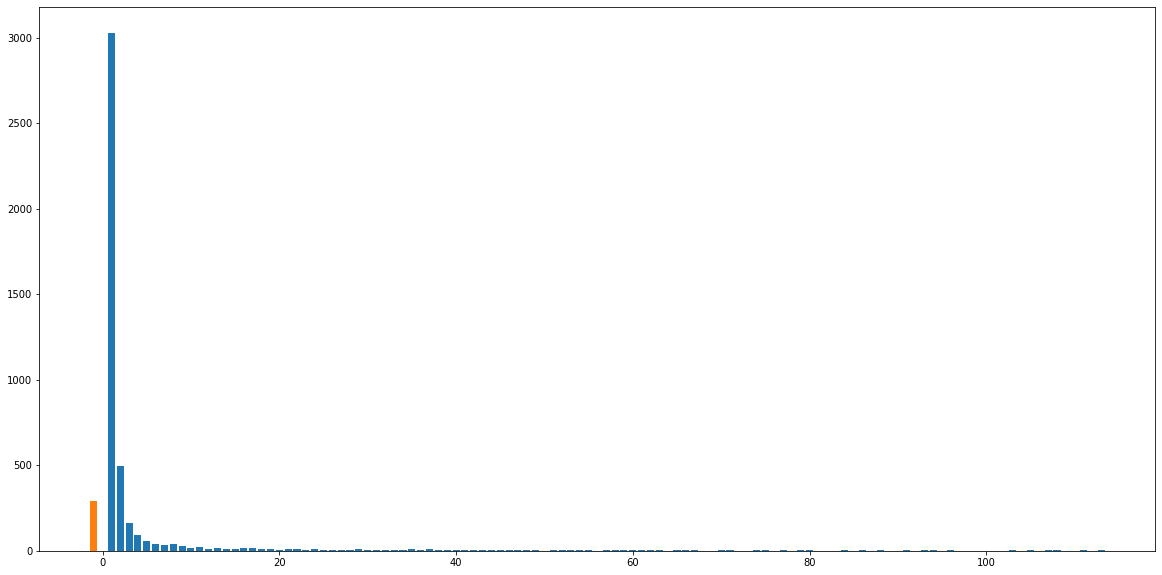

In [32]:
fig = plt.figure(figsize=[20,10])

plt.bar(position_distribution[0][:100], position_distribution[1][:100])
plt.bar(-1, 289)

plt.show()

In [1]:
3026/4625

0.6542702702702703

In [2]:
289/4625

0.062486486486486484

In [22]:
pd.DataFrame(expanded_queries_not_returned_BM25)

,query-id,positive_doc_id
0,8,twl9xy28
1,9,twl9xy28
2,33,23eejhuw
3,35,23eejhuw
4,77,fqmmyjgj
...,...,...
284,4799,b4fk0dr5
285,4801,b4fk0dr5
286,4802,b4fk0dr5
287,4809,vynq2t0h


In [23]:
expanded_queries_df

,query,positive_doc_id,negative_doc_ids
0,What are the benefits of international cooperation in the field of medicine for mass gatherings?,pxniqk3i,"[nku844kt, xilenqax, cgcuzxdt, ing711rk, dgvhzxlu, fzthd8c0, zvdblh8r, jh34klbg, 79l7wsc0, mvh4ig2g, za6x4reh, do111e5s, 4igvc039, oqmt78e8, gerhoy8w, obph3gup, rd6cqdsf, cakplpzq, fsly6gph, fcuwzpfy]"
1,How has progress in mass gathering medicine been achieved through international cooperation?,pxniqk3i,"[esggkw4u, y3fhubnc, 60u7muhc, jzyn6swh, j00jj2og, 1e4dzy64, qmcbsqse, uq80ybb0, 3n890yha, 41nebtwm, 4uzf5uue, j1h7b44j, 7lyccvm5, gqjcvxln, 6jgao58w, v3vxhqi4, r71awxo0, qhay7qao, ljjry7gt, hq8dg87u]"
2,What challenges have been overcome with the help of international cooperation in the field of mass gatherings medicine?,pxniqk3i,"[271xb1ls, s5b9q5n0, w933g6mm, efkjyd1k, 8ynk9k8r, vltscf9v, q2k2krnm, bljjcfd6, dpsgeko0, hltiva9i, tzgg27ge, s2q6g91b, 22eneg79, qh63b6sy, u592mbw6, blzjj06v, fk7k84n7, sdtiyrab, j2sq9kof, vb4eyjyu]"
3,What have been the most successful initiatives in international cooperation for mass gatherings medicine?,pxniqk3i,"[45k6tp0b, aqgauumt, iec4mvh7, e8yxnh27, 99b09xpi, l346qqwp, z6vddid9, fsojj7m5, vb4eyjyu, 2jd7aa2d, ptfhjlav, mgn5x4f5, j2sq9kof, 8ldkbl2g, aso63o3p, ncr8i4z3, fk7k84n7, 74txzvou, 6qz7bqnb, m5ptobvz]"
4,How can international cooperation be further improved to promote progress in mass gatherings medicine?,pxniqk3i,"[emnln2ix, pux58dut, aza0pzud, zaz1e2cf, ax3i3d7f, rxzsty8t, 4bh701xz, 1v4frt83, dfb3512i, lvm5ej0c, 7xxcl2ug, hnrlem31, v9y7xpnj, 294aqph9, 74qmy02h, td5xxbsl, 2z32ln7g, jxwyyv9o, trtikw3s, t35n7bk9]"
...,...,...,...
4909,What is the role of GBF1 in poliovirus replication?,lxb2otpr,"[h2cm3cge, d441jam3, 3kmqy07w, tg0tczni, j6zirpyz, dlmx12vt, 9v0z2chz, ue15waq7, kjyuxc3g, 7oat5jiw, 2ec3arfc, 4s0keus5, 4zphlpks, 0u62j7nj, ngxy58tg, 11m9uz3n, jomutdxf, frkb8iso, 00a19z5i, 3q9yr6np]"
4910,How does the presence of BFA affect polio replication?,lxb2otpr,"[0u62j7nj, 8jnrc01n, k9dl79kc, jc4ckqy7, c3g3hrm2, u8otoxn4, ahrrphm8, gzdtdmx6, ync7cwq2, g9ykr72y, m22h669g, jjocpkh9, w1q46y63, w4emoao6, xyo2l9u4, m3dt5kuy, nm8gdeyc, rebll0rk, vori28fm, j6i1hpbj]"
4911,Does the N-terminus domain of GBF1 have any role in Arf GTPase activation?,lxb2otpr,"[3jxi0dj2, bpnqz1cn, pujlr8uf, ywanv2la, u9u0y5ju, 3tfqtdbg, wrkl39sf, rnkawxrq, 3ury4hnv, 2s3x6sj8, firlsrg9, lfmtmqju, oshi71yw, d2algx16, e2qq4ngq, 0bnfugdm, 5qnayf72, gxe3kwtu, x04w3l3f, 7nh3m8l8]"
4912,How does the absence of p115 and Rab1b influence poliovirus replication?,lxb2otpr,"[dcmz4wcn, 413m7czk, qnntyqud, 8ut2p9p6, 5gp8wg9w, btbv4rq0, r01ii1bu, qsg18lbc, 73sxbpng, 1n127fkf, rsycde29, j2bb6eq8, ejtvvbck, 6vj79mqh, 8detpwvu, ghqtxrvt, 5hm0jr7u, 788zjhkn, 1fp4ck88, ixnafpv7]"


In [24]:
with open("eduseiti_1000_queries_expansion_20230502_02.jsonl", "w") as outputFile:
    for i, query in expanded_queries_df.iterrows():
        if i > 0:
            outputFile.write("\n")
        
        query_dict = {"query": query['query'],
                      "positive_doc_id": query['positive_doc_id'],
                      "negative_doc_ids": query['negative_doc_ids'].tolist()}
        
        print(query_dict)
        
        json.dump(query_dict, outputFile)

{'query': 'What are the benefits of international cooperation in the field of medicine for mass gatherings? ', 'positive_doc_id': 'pxniqk3i', 'negative_doc_ids': ['nku844kt', 'xilenqax', 'cgcuzxdt', 'ing711rk', 'dgvhzxlu', 'fzthd8c0', 'zvdblh8r', 'jh34klbg', '79l7wsc0', 'mvh4ig2g', 'za6x4reh', 'do111e5s', '4igvc039', 'oqmt78e8', 'gerhoy8w', 'obph3gup', 'rd6cqdsf', 'cakplpzq', 'fsly6gph', 'fcuwzpfy']}
{'query': 'How has progress in mass gathering medicine been achieved through international cooperation? ', 'positive_doc_id': 'pxniqk3i', 'negative_doc_ids': ['esggkw4u', 'y3fhubnc', '60u7muhc', 'jzyn6swh', 'j00jj2og', '1e4dzy64', 'qmcbsqse', 'uq80ybb0', '3n890yha', '41nebtwm', '4uzf5uue', 'j1h7b44j', '7lyccvm5', 'gqjcvxln', '6jgao58w', 'v3vxhqi4', 'r71awxo0', 'qhay7qao', 'ljjry7gt', 'hq8dg87u']}
{'query': 'What challenges have been overcome with the help of international cooperation in the field of mass gatherings medicine?', 'positive_doc_id': 'pxniqk3i', 'negative_doc_ids': ['271xb1ls',

{'query': 'What alternative policies might be used to fairly rank teams in incomplete tournaments without promotion, relegation, and qualification for international cups?', 'positive_doc_id': 'dbwmdxpm', 'negative_doc_ids': ['rrbw8mdk', 'csxud6f1', 'd12eavcu', 's7ox0h4f', 'h7sxkqw7', 'pruqumjs', 'pbhzmaju', 'zvb7bxix', 'dq8hvh8f', 'whm2ce4u', 'yxsbjgvf', 'cba8gycz', 'fk7k84n7', 'kxffw4e4', '1he26n1o', 'ufj13ky2', '9uwj54b9', 'xf4yy6i1', 'ggsljh21', 'ccddv4cd']}
{'query': 'What are the common bacterial, viral, and fungal pathogens that cause hospital-acquired pneumonia?', 'positive_doc_id': 'yw9ine1e', 'negative_doc_ids': ['0ahvoak4', 'd9sy1vby', 't9na5ufi', 'ylblm83c', 'acrblprf', '6ialz79k', 'p8a6hqi9', '30zjs8vr', '5br8midr', 'vvaeewal', 'f1dukpso', '3esrg1jw', 'l1tvmxm8', '5cgj11ls', 'vz2nsx2d', 'sqgupxp6', 'w2s2p4dt', 'o7qfugjw', '88qpfu6b', 'hadwwjkx']}
{'query': 'What is the definition of ventilator-associated pneumonia?', 'positive_doc_id': 'yw9ine1e', 'negative_doc_ids': ['yn53

{'query': 'How do the infection rates among Chinese health workers compare to other healthcare professionals in other countries?', 'positive_doc_id': 'gdxr31co', 'negative_doc_ids': ['upnr3j7x', 't9hufrj0', '0xqxledk', 'e4rawhl6', 'fiuo2z9w', 'clsrt0dw', 'sl5hwxt4', 'qwe1hni0', '7el8o6qq', 'k9r1msud', 'sfya6yfi', 'i1gdsiw6', 'uxbbmga2', 'bazmtjtj', 'emf842rj', 'o01w28gb', 'vsrblj3x', '6abo7krb', 'dv14oad8', 'drlj2ps4']}
{'query': 'What strategies have been employed to protect health workers from being infected with SARS-CoV-2?', 'positive_doc_id': 'gdxr31co', 'negative_doc_ids': ['ovvyq18n', '4qy35wdf', 't3zhqrs9', '8earvduw', '1t8fn28l', 'vklc2ocs', '12dfuqtq', '42iozvo8', 'juvmabdq', 'r0k1rfmt', 'nhgc6wcg', 'gvenywfc', '0bbxyyea', 'ac5c1s6n', 'k3bkgf1g', 'sygpgksn', '554iw63z', '9jwma2y6', 'l398ffbi', '7u41zswj']}
{'query': 'What are the global estimates for newly diagnosed breast cancer cases in 2018? ', 'positive_doc_id': 'dxbhz24p', 'negative_doc_ids': ['yw7psy0a', 'cgdrcjfq', '64

{'query': 'What viral diseases are caused by viruses?', 'positive_doc_id': 'bnnw8cpn', 'negative_doc_ids': ['czeyghyy', 'lnch3qsq', 'u4i5tmey', '6gyo9rya', 'bcfgvu2e', '3k1tiuby', 'rtby02q1', '9x2z2hg1', 'vyqfh4uo', '53bw4z9u', 'yz154qjd', 'adiqqmxh', 'bo215gm9', 'm7mhyrp8', 'j4iwq2ld', 'bx9fzxvy', 'hcd34m7b', '9uyxxu9j', '5mtmvl7r', 'n5lg43tr']}
{'query': 'What role do viruses play in evolution?', 'positive_doc_id': 'bnnw8cpn', 'negative_doc_ids': ['zb98grls', 'r35fd6v0', 'fes59m2e', '1bfxhwx6', 'nimh39bx', '876vvri8', 'ulox16cc', 'qwub35cd', '0e1w86tg', 'kix0a6l1', 'vefs1h6o', '81znlofa', 'y84dufy4', '096gtdy5', 'w7z97wir', 'gthanxy9', 'walpfa6r', '2jccfcun', 'zh30tvgb', '24pp67fw']}
{'query': 'What are the implications of silent codes in viral genomes for gene expression regulation?', 'positive_doc_id': 'bnnw8cpn', 'negative_doc_ids': ['2a9jgh37', 'i8ukefp8', 'pqmaays5', 'phkoh08y', 'ooj9yqbx', 'wftuiizr', 'vje3uoq0', 'ginn5rvy', 'kxq5pw7b', 'nogoqyxl', 'n952re94', 'yb3oohic', 'mnx8

{'query': 'How long did the study last?', 'positive_doc_id': 'f65nhifx', 'negative_doc_ids': ['8d1076ge', 'hdpmxu9p', '1cnhsnai', '3yyozufy', 's48rc7se', 'x7or04u6', 'vxo7vupg', 'pnr3rtr1', '651uz4ev', 'qmgdvdlb', '9z0886kb', '3unwyjdq', 'i64q5d26', '13mq0cw6', 'bgp8mbye', 'boqyloeu', '1kwb0v71', '9jatvium', '5iofpvx2', '85pk9441']}
{'query': 'What role does Legionella pneumophila play in childhood illness?', 'positive_doc_id': 'f65nhifx', 'negative_doc_ids': ['tfazq3vk', 'tmfm5u5h', 'daaenmo9', 'vbatmmtr', 'yjytp2mc', 'z4vl8lat', 'qfvxyb5e', 'nvw6fyin', 'n234byv0', '99b09xpi', '1q5b3gug', 'pfryji0y', 'c3zqtasi', '8f6n5m2y', 'll4xf8ei', 'hug3pz1m', 'njg0ln33', 'k30mv20e', 'c5be70t6', '0ahn7xlo']}
{'query': "Is Legionnaires' disease a common cause of acute respiratory disease in early childhood?", 'positive_doc_id': 'f65nhifx', 'negative_doc_ids': ['rl4v3k7g', 'o4ofqk5e', 'xvtt8fz8', 'rlygmpr9', 'su6vhs49', 'bbxipprz', 'tomsdx3z', 'oub52ns2', 'zz4cczuj', 'bqdczm7s', '8e2nctvz', '0ubbqim

{'query': 'Are there any other health benefits of phototherapy during the COVID-19 pandemic?', 'positive_doc_id': 'b88d5igl', 'negative_doc_ids': ['5hfxj821', 'pdvqdgsw', 'gplersk4', 'kqbwzakx', '2g0obbqp', '6shiocwr', '52pibisk', 'htda3o4a', 'qwylfihl', '5tydrrz1', 'wml89mqb', 'wll4hpu5', 'woz5f3gh', 'v49bgnqk', 'cwuz9hg6', '8v2rpcjd', 'wka377g9', 'mfjvtkyv', 'ma7gytcz', 'nwtfs1t9']}
{'query': 'Does phototherapy have any side effects that should be considered before treatment?', 'positive_doc_id': 'b88d5igl', 'negative_doc_ids': ['nf6ouaq3', 'lz831dky', 'z3esk2dk', '22gzjnor', 'r9l4nsaa', 'yzb1o7am', 'q5mnjg3c', 'dqn4fur3', 's8b4j0j2', '0a371595', '06y4olcv', 'zbt4bo4f', '5d2im3oo', '3aaw7toy', 'n6fuxksg', '2514emrh', 'svo94kuo', 'o7ava60q', '2xnfd3jq', 'vuvpn58q']}
{'query': 'Is vitamin D supplementation proven to be effective in preventing or treating COVID-19?', 'positive_doc_id': 'b88d5igl', 'negative_doc_ids': ['0rn439n7', 'snrpl1oz', 'xhh2n6w7', '00tzl4io', 'dvg0isgt', 'fc4sg70b

{'query': 'What methods have been used in the past for the management of anastomotic leak after LAR?', 'positive_doc_id': '2in370n2', 'negative_doc_ids': ['2ntfeoqs', '9ds4y4f5', 'f5rto51t', 'm5g3s1oz', '7k2n1dkk', 'wupv5nrq', 'qq4zjoyn', '4pgflner', 'unj4sj56', 'pyqqcbbb', 'ntot1wng', 'dd8aj4ux', 'chcbiott', '6nbzpi5j', 'f3sre07i', 'gyjnx4zy', 'hls2h9ij', 'u14afdat', 'p7id3jpk', '608l7eww']}
{'query': 'Are there any potential complications associated with the use of TEM debridement and repair in the management of anastomotic leak after LAR?', 'positive_doc_id': '2in370n2', 'negative_doc_ids': ['b8qynet9', 'wht09as5', 'bdxva84f', 'ktb7qsq5', '14cnvnln', '9exf707y', '7b4cuzsg', 'r1fxadfz', '36bxoisi', 'cbmefgcj', 'mw2odze7', 'h1fggiri', 'qpy2aus9', 'kb1bof2e', 'hkwu7p0n', 'so9f9l05', '7yi7tcc7', 'lh14ifi5', '574j7f1v', 'gbzdp48u']}
{'query': 'podcast?', 'positive_doc_id': 'e4ir6zub', 'negative_doc_ids': ['a27goa1o', 'lk9pmujz', 'wqqfpr4g', 'si9e7t09', 'upnhy156', 'qndmwv1d', 'efgozm3d',

{'query': 'What evidence is there that allergen immunotherapy is effective in treating IgE-mediated allergies?', 'positive_doc_id': '8e34ndn4', 'negative_doc_ids': ['m63b9ekk', 'phk6df4n', 'xphfm3hf', 'kkuak8qc', 'ntv2g7ne', 'lpur34p7', 'ualiek2k', 'h7ccnk65', '2j1hbdvt', 'yzqla4tn', '0xylok5d', '4bzw76lt', '9edgd94l', 'k50qvr4w', 'zjsjgd31', 'o4u0os84', '34nnp9cv', 'fl0ouw9y', 'q259v3rr', 'elyekavx']}
{'query': 'What recommendations have been made by the ARIA-EAACI regarding the handling of allergen immunotherapy during the COVID-19 pandemic?', 'positive_doc_id': '8e34ndn4', 'negative_doc_ids': ['cukhr8zk', 'wguvz5w7', 'z7rgaufl', 'p37kv4va', '3d04p4xp', 'uu4k2j2a', 'znogutwp', 'gvxuz8jt', '50chmcow', '2w05l8r6', 'ozggtbhj', 'qw4az7dd', 'satufg9w', 'vpn82f1x', 'eazqdlds', 'nfklfcw6', '2514emrh', 'qcnw8i2f', 'qpw7a6xg', 'rl7vrv9i']}
{'query': 'What are the potential long-term benefits of allergen immunotherapy for IgE-mediated allergies?', 'positive_doc_id': '8e34ndn4', 'negative_doc_i

{'query': 'What factors should be considered when selecting a thermometer to use during the COVID-19 pandemic?', 'positive_doc_id': 'sks5ruy3', 'negative_doc_ids': ['3nk9kvdy', 'ntv2g7ne', 'ddha1w0v', 'tm1iuor1', 'ez6kbb30', 'e563p9av', 'ttzij9mk', '0sszoalm', 'i67ev9rg', 'yml9wuer', '8ujd01pr', 'qg4xl5w8', 'wskmzg7d', 'f6rzgfud', 'nikb0elz', 'cwuz9hg6', 'qcr1fl8s', 'a3fz514d', 'ovowpb9q', 'bn8y4lew']}
{'query': 'Are there any thermometer types that are more reliable than others during the COVID-19 pandemic?', 'positive_doc_id': 'sks5ruy3', 'negative_doc_ids': ['fc0twyih', 'x5nql0cw', 'kqbwzakx', 'we8bccga', 'fmrnxa2h', 'pzgqvmaj', 'weoxwksv', '45v6b4tc', 'pga0ljzr', 'rmc6otlc', '7y8sk85t', 'g06slmk3', 'hlhfx3fm', 'sjtu4kn5', 'nakss8ag', '6gn9dp5k', '6knskl5l', '0uengr9t', 'mpl4yrxa', 'j3pf5afx']}
{'query': 'How can the accuracy of thermometers be tested to ensure they are providing reliable readings during the COVID-19 pandemic?', 'positive_doc_id': 'sks5ruy3', 'negative_doc_ids': ['i